In [2]:
# https://github.com/plaidml/plaidml
# https://informatics.sydney.edu.au/blogs/amdgpu/

# Install the plaidml backend
import plaidml.keras
plaidml.keras.install_backend()

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [3]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5]
redice_lr_patient = [5]

INFO:plaidml:Opening device "opencl_amd_gfx902.0"


In [10]:
from keras.callbacks import ReduceLROnPlateau
import itertools

results = {}

for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/iambenben/2nd-ml100days-day087/0b6c6f2c179348d0964a66102d19b6c3



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/iambenben/2nd-ml100days-day087/0b6c6f2c179348d0964a66102d19b6c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [49]           : (0.26783999996185304, 0.6472599997711181)
COMET INFO:     batch_acc [249]    : (0.1083984375, 0.673828125)
COMET INFO:     batch_loss [249]   : (0.9611742496490479, 2.9727206230163574)
COMET INFO:     epoch_duration [49]: (3.4530000000086147, 12.125)
COMET INFO:     loss [49]          : (1.0330119959640502, 2.209027486305237)
COMET INFO:     lr [49]            : (0.0010000000474974513, 0.0010000000474974513)
COMET INFO:     step               : 1225
COMET INFO:     val_acc [49]       : (0.1823999997138977, 0.5007000002384185)
COMET INFO:     val_loss [49]      : (1.4323662200927734, 2.1466708084106445)
COMET INFO:   Other [count]:
COMET INFO:     trainable_params: 923914
COMET INFO: ---------------------

Numbers of exp: 1, reduce_factor: 0.50, reduce_patient: 5


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/iambenben/2nd-ml100days-day087/599baba0b18e41fabafd9fa57976fbe0



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
__________

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/iambenben/2nd-ml100days-day087/599baba0b18e41fabafd9fa57976fbe0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [49]           : (0.38088000009536743, 0.8898400004577637)
COMET INFO:     batch_acc [249]    : (0.1083984375, 0.9140625)
COMET INFO:     batch_loss [249]   : (0.3779233992099762, 3.0132250785827637)
COMET INFO:     epoch_duration [49]: (3.860000000000582, 11.514999999999418)
COMET INFO:     loss [49]          : (0.40383487760543824, 1.7872870488357544)
COMET INFO:     lr [49]            : (0.0001250000059371814, 0.0010000000474974513)
COMET INFO:     step               : 1225
COMET INFO:     val_acc [49]       : (0.17399999985694886, 0.5226999971389771)
COMET INFO:     val_loss [49]      : (1.428835105895996, 2.411497681427002)
COMET INFO:   Other [count]:
COMET INFO:     trainable_params: 923914
COMET INFO: -----------

Numbers of exp: 2, reduce_factor: 0.50, reduce_patient: 5


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/iambenben/2nd-ml100days-day087/6a4739e560c7488bb0a296ff97f1698e



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
__________

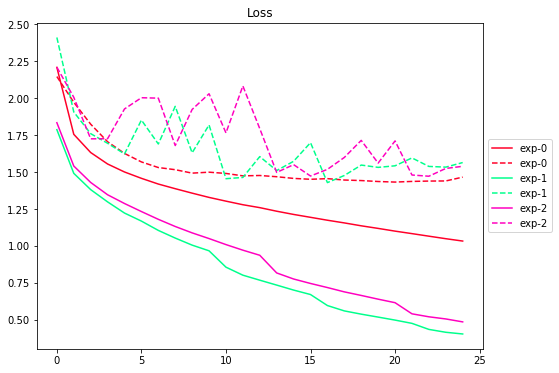

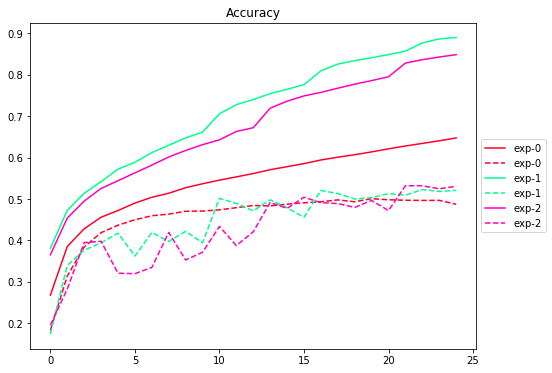

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()